<xarray.Dataset> Size: 5MB
Dimensions:           (band: 15, x: 274, y: 275)
Coordinates:
  * band              (band) int64 120B 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
  * x                 (x) float64 2kB 3.127e+05 3.127e+05 ... 3.208e+05
  * y                 (y) float64 2kB 4.886e+06 4.886e+06 ... 4.877e+06
    spatial_ref       int64 8B 0
Data variables:
    landsat           (band, y, x) float32 5MB ...
    corine_landcover  (y, x) float32 301kB 115.0 115.0 115.0 ... 114.0 114.0
    elevation         (y, x) float32 301kB 503.0 510.0 514.0 ... 497.0 495.0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      ('B1', 'B2', 'B3', 'B4', 'B5', 'B6_VCID_1', 'B6_VCID_2', ...

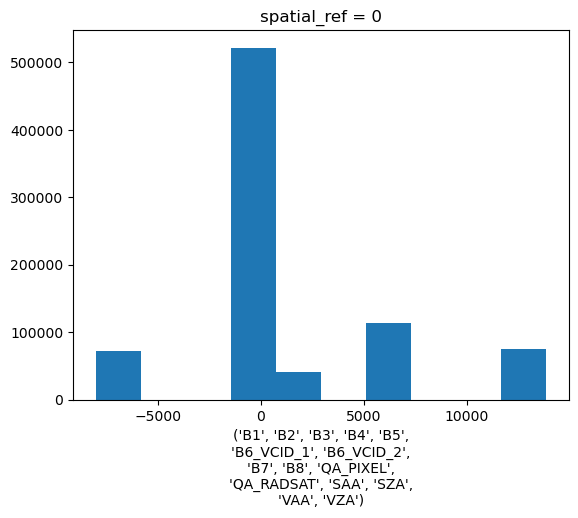

In [24]:
from scripts.imports import *
from rasterio.enums import Resampling

def find_masks(folder, cam):
    for filename in os.listdir(folder):
        if cam in filename and 'LandCover' in filename:
            corine_filepath = os.path.join(folder, filename)
        elif cam in filename and 'ALOS' in filename:
            elevation_filepath = os.path.join(folder, filename)
    return corine_filepath, elevation_filepath

def load_and_reproject_to_landsat(source_path, match_array, band_name, method=Resampling.nearest):
    src = rioxarray.open_rasterio(source_path, masked=True).squeeze()
    src.name = band_name
    return src.rio.reproject_match(match_array, resampling=Resampling.nearest)

def combine_tifs(landsat_filepath, corine_filepath, elevation_filepath):
    landsat = rioxarray.open_rasterio(landsat_filepath, masked=True).squeeze()
    landsat.name = "landsat"

    corine = load_and_reproject_to_landsat(corine_filepath, landsat, "corine_landcover", method=Resampling.nearest)
    elevation = load_and_reproject_to_landsat(elevation_filepath, landsat, "elevation", method=Resampling.nearest)

    ds = xr.merge([landsat, corine, elevation])
    return ds

cams = ['bartlett', 'delta_junction', 'glees', 'hyytiala', 'kenttarova', 'lacclair', 'marcell', 'old_jack_pine',\
        'oregon', 'queens', 'sodankyla', 'torgnon', 'underc', 'underhill', 'varrio', 'willowcreek', 'wslcreek'] #no tammela

landsat_folder = '../scratch/data/landsat/'
landsat_filepaths = [os.path.join(landsat_folder, f) for f in os.listdir(landsat_folder) if\
                     os.path.isfile(os.path.join(landsat_folder, f))]
landsat_filepaths.sort()

landsat_masking_folder = '../scratch/data/landsat_masking/'
cam = [c for c in cams if c in landsat_filepaths[0]][0]
corine_filepath, elevation_filepath = find_masks(landsat_masking_folder, cam)

ds = combine_tifs(landsat_filepaths[0], corine_filepath, elevation_filepath)
ds['landsat'].plot()
ds
# landsat_filepaths, corine_filepath, elevation_filepath